In [2]:
# Importamos las librerías necesarías y fijamos la semilla
import numpy as np
import random
import scipy
from scipy.stats import uniform as spuniform
import matplotlib.pyplot as plt

from matplotlib import pyplot
import math
import statistics
import pandas as pd
import time
!pip install networkx
import networkx as nx

from matplotlib import colors

np.random.seed(11)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 103.1 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [1]:
def timeSince(since):
    now = time.time_ns()
    s = now - since
    return s*10**(-9)

Definimos la función grafoM que crea un mapa con la estructura de regiones con provinicas a partir de una lista P que informe el número de provinicas por región:

In [2]:
def grafoM(P):
    G = nx.DiGraph()
    V = sum(P[i] for i in range(len(P)))
    G.add_nodes_from(range(V)) #agregamos los vértices de un grafo
    R = {}
    for i in range(len(P)):
        pi = []
        for p in range(P[i]):  #crea una tupla (x,y) posición de la provincia
            pi.append(np.array([np.random.uniform(), i + np.random.uniform()]))
        R[i] = pi
    C = {}
    for r in R:
        if r < len(R)-1: #definimos el costo de cada arista
            C[r]= {}
            for j in range(len(R[r])): 
                C[r][j]= []
                for k in range(len(R[r+1])): #costo definido como distancia euclideana
                    C[r][j].append(np.linalg.norm(R[r][j] - R[r+1][k])) 
    E = []
    k=0
    for i in range(len(P)-1):
        for j in range(P[i]):
            for h in range(P[i+1]):
                E.append((k+j,k+P[i]+h, {"weight": C[i][j][h]} ))
        k+=P[i]
    G.add_edges_from(E)        
    return G , R , C

In [3]:
#se define el costo de una ruta como la suma de los costos de cada arista
def costo(ruta,distancias):
    S = 0
    for i in range(len(ruta)-1):
        inicio = ruta[i][1] #donde estoy
        fin = ruta[i+1][1] #donde voy
        S += distancias[i][inicio][fin] #sumo costo
    return S

Aplicamos Simulated Annealing. Para esto se requiere:

- mapa: un grafo creado con la función grafo
- distancias: costos asociados a las aristas del grafo anterior.
- sigma0: configuración (ruta) inicial.
- C: ponderador aplicado a la función $\beta$.
- beta: función beta para crear sucesión $\beta_n$.


In [4]:
def SimAnn(mapa,distancias,sigma0,C,beta,pasos=10**4):
    U = np.random.uniform(size = pasos) #se define las uniformes para cada paso
    sigmas = [sigma0] #almacenamos las configuraciones
    w = [costo(sigma0,distancias)] #almacenamos los costos de cada iteración
    conteo=0
    for i in range(pasos-1):
        sigma= sigmas[i] #configuración anterior
        betan= beta(i,C) #definimos beta_n segun la función dada
        #definimos el vecino
        region = np.random.randint(1,len(mapa)-1) #en qué región cambiar
        provincias = [i for i in range(len(mapa[region])) if i != sigma[region][1]] #provincias de la region menos la tomada
        prov = np.random.choice(provincias) #elijo a qué provincia cambiar
        #construimos el vecino
        tau = [sigma[0]]
        for j in range(1,len(sigma)):
            if j == region: #estoy en la región de cambio
                tau.append((j,prov))
            else:
                tau.append(sigma[j])
        ws = costo(sigma,distancias) #costo anterior
        wt = costo(tau,distancias) #costo vecino
        dif = np.exp(-betan*(wt-ws))
        #print("betan:",betan,"ws:",ws,"wt:",wt,"dif:",dif)
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(costo(tau,distancias))
        else:
            sigmas.append(sigma)
            w.append(costo(sigma,distancias))
    #print("transiciones hechas:",conteo)
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas



Hacemos la prueba sobre un mismo grafo, cambiando la sucesión de $\beta_n$ y los parámetros C y los pasos del Simmulated Annealing:

In [6]:
def beta1(n,C): #beta lineal
    return n/C

def beta2(n,C): #beta cuadrático
    return (n**2)/C

def beta3(n,C): #beta exponencial
    return np.exp(n)/C

In [7]:
#transforma el formato de una ruta u,v,y a (0,u),(1,v),(2,y)
def camino(ruta,ciudad):
    A=[]
    k=0
    for i in range(len(ruta)):
        A.append((i,ruta[i]-k))
        k+= len(ciudad[i])
    return A

Definimos una función que dibuja una ruta en la grilla del país. Para esto se le entrega:

- $\sigma$: una ruta del mapa.
- ciudades: el mapa de las ciudades.

También se puede entregar de manera opcional:

- p: otra ruta del mapa para comparar con $\sigma$.
- index: lista de índices de $\sigma$ que se desean destacar.

In [33]:
#sigma una configuración como secuencia de vértices
def plotear(sigma,ciudades,p=[],index=[]):
    plt.figure()
    #graficar provincias
    X= [ciudades[i][j][0] for i in range(len(ciudades)) for j in range(len(ciudades[i]))]
    Y= [ciudades[i][j][1] for i in range(len(ciudades)) for j in range(len(ciudades[i]))]
    plt.scatter(X,Y, marker="o")
    plt.scatter(X[0],Y[0],marker="x", color="g")
    plt.scatter(X[-1],Y[-1],marker="x", color="g")
    for i in range(len(R)):
        plt.axhline(y = i, color = 'b', linestyle = '-')
    for i in range(len(sigma)-1):
        plt.plot([ciudades[sigma[i][0]][sigma[i][1]][0],ciudades[sigma[i+1][0]][sigma[i+1][1]][0]],[ciudades[sigma[i][0]][sigma[i][1]][1],ciudades[sigma[i+1][0]][sigma[i+1][1]][1]],'k-')
    if len(index)>0:
        for i in index:
            plt.plot([ciudades[sigma[i][0]][sigma[i][1]][0],ciudades[sigma[i+1][0]][sigma[i+1][1]][0]],[ciudades[sigma[i][0]][sigma[i][1]][1],ciudades[sigma[i+1][0]][sigma[i+1][1]][1]],'k-',color="r")
    for i in range(len(p)-1):
        plt.plot([ciudades[p[i][0]][p[i][1]][0],ciudades[p[i+1][0]][p[i+1][1]][0]],[ciudades[p[i][0]][p[i][1]][1],ciudades[p[i+1][0]][p[i+1][1]][1]],'k-',color= "g")
  

## Simulación de evaluación

Comenzamos creando un grafo cualquiera.

In [10]:
P= [2,2,3,3,3,8,6,3,4,3,3,2,2,4,4,4] #lista del número de provincias por región
G,R,C = grafoM(P)

Encontremos de inmediato el camino más corto desde el nodo 0 al último nodo:

In [11]:
p = nx.shortest_path(G,0,len(G.nodes)-1,"weight")
p= camino(p,R)
#nx.path_weight(G,p,"weight")

Procedamos a realizar el S.A., primero definimos los parámetros:

In [12]:
c = [1,5,10,100]
pasos = [10**2, 10**3, 10**4]

Luego creamos una ruta aleatoria para comenzar:

In [13]:
ruta = [(0,0)]
for i in range(1,len(R)-1):
    ruta.append((i,np.random.randint(0,len(R[i]))))
ruta.append((len(R)-1,len(R[len(R)-1])-1))

Se realizan distintas iteraciones de S.A. según cada parámetro, con 1.000 pasos.

In [14]:
i=2

s10,w10,W10,S10 = SimAnn(R,C,ruta,c[0],beta1,pasos[i])
s11,w11,W11,S11 = SimAnn(R,C,ruta,c[1],beta1,pasos[i])
s12,w12,W12,S12 = SimAnn(R,C,ruta,c[2],beta1,pasos[i])
s13,w13,W13,S13 = SimAnn(R,C,ruta,c[3],beta1,pasos[i])

s20,w20,W20,S20 = SimAnn(R,C,ruta,c[0],beta2,pasos[i])
s21,w21,W21,S21 = SimAnn(R,C,ruta,c[1],beta2,pasos[i])
s22,w22,W22,S22 = SimAnn(R,C,ruta,c[2],beta2,pasos[i])
s23,w23,W23,S23 = SimAnn(R,C,ruta,c[3],beta2,pasos[i])

s30,w30,W30,S30 = SimAnn(R,C,ruta,c[0],beta3,pasos[i])
s31,w31,W31,S31 = SimAnn(R,C,ruta,c[1],beta3,pasos[i])
s32,w32,W32,S32 = SimAnn(R,C,ruta,c[2],beta3,pasos[i])
s33,w33,W33,S33 = SimAnn(R,C,ruta,c[3],beta3,pasos[i])

/tmp/ipykernel_89/3523960334.py:22: RuntimeWarning: overflow encountered in exp
  dif = np.exp(-betan*(wt-ws))
/tmp/ipykernel_89/1310140509.py:8: RuntimeWarning: overflow encountered in exp
  return np.exp(n)/C


### Evaluación de Simulaciones

Veamos la evolución de la función de energía (distancia total de la ruta) para cada método según el parámetro C.

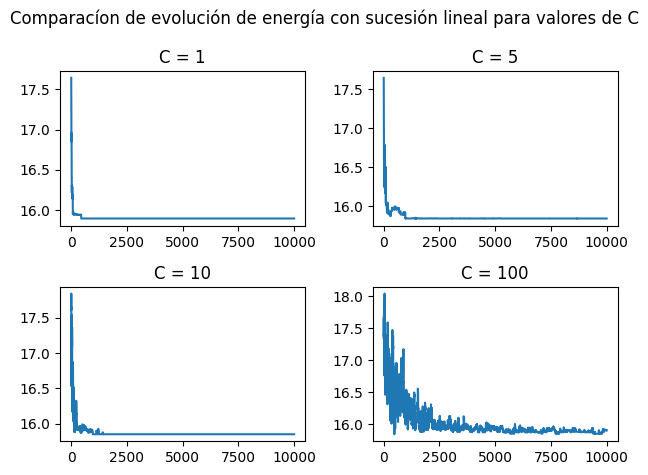

In [15]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(X,W10)
axs[0,1].plot(X,W11)
axs[1,0].plot(X,W12)
axs[1,1].plot(X,W13)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')
fig.suptitle("Comparacíon de evolución de energía con sucesión lineal para valores de C")
fig.tight_layout()

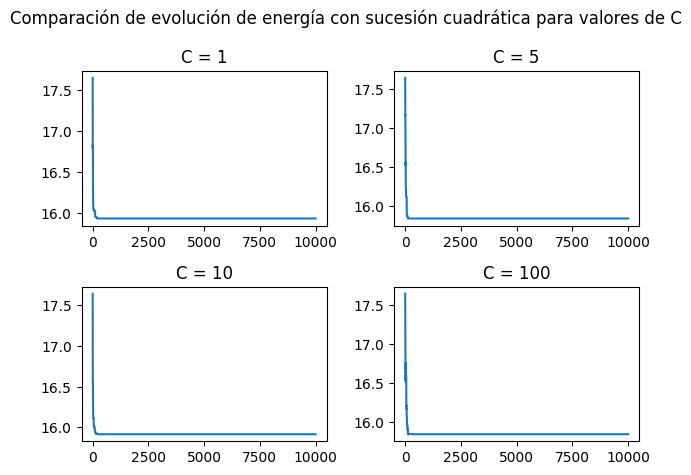

In [16]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(X,W20)
axs[0,1].plot(X,W21)
axs[1,0].plot(X,W22)
axs[1,1].plot(X,W23)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')
fig.suptitle("Comparación de evolución de energía con sucesión cuadrática para valores de C")
fig.tight_layout()

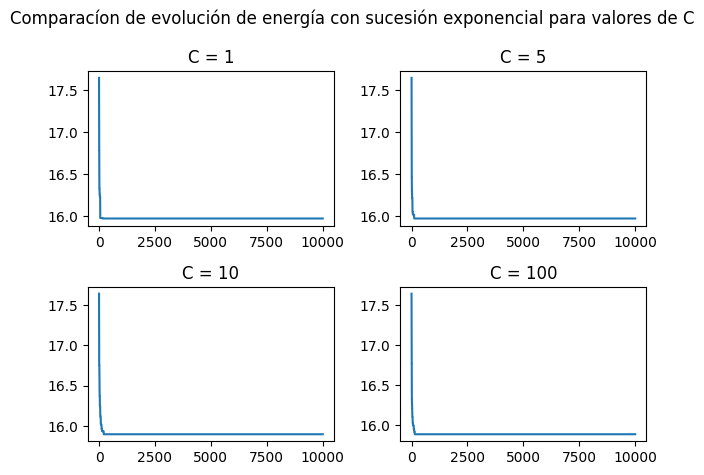

In [17]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(X,W30)
axs[0,1].plot(X,W31)
axs[1,0].plot(X,W32)
axs[1,1].plot(X,W33)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')
fig.tight_layout()
fig.suptitle("Comparacíon de evolución de energía con sucesión exponencial para valores de C")
fig.tight_layout()

Evaluamos los costos de cada camino encontrado al final del Annealing, comparando con el óptimo original encontrado con Dijkstra:

In [17]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [costo(s10,C), costo(s20,C), costo(s30,C)],"C=5": [costo(s11,C), costo(s21,C), costo(s31,C)] 
    ,"C=10": [costo(s12,C), costo(s22,C), costo(s32,C)],"C=100": [costo(s13,C), costo(s23,C), costo(s33,C)], "Dijkstra": [costo(p,C) for i in range(3)]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100,Dijkstra
0,Lineal,15.889633,15.838588,15.849210,15.901354,15.838588
1,Cuadrático,15.930320,15.838588,15.914587,15.838588,15.838588
2,Exponencial,15.968557,15.968557,15.894219,15.883597,15.838588


Para evaluar más mapas distintos, definimos la función simulación que realice el procedimiento anterior (correr 12 Annealings con distintos parámetros) para un grafo con número de regiones y de provincias aleatorio.

La funcion entrega:
- si: un valor binario (0 u 1) si alguna de los 12 Annealings llegó al óptimo.
- td: tiempo que tardó Dijkstra en encontrar la solución.
- T: tiempo promedio de los 12 Annealings.
- winners: lista de Annealings que llegaron al óptimo.
- twinners: tiempo de ejecución de los Annealings en winners.

In [45]:
def simulacion(tol = 0.01):
    n = random.randint(3,30) #numero de regiones
    P = [np.random.randint(2,10) for i in range(n)] #numero de provincia para cada region
    G,R,C = grafoM(P)
    c = [1,5,10,100]
    pasos = [10**2, 10**3, 10**4]
    ini = random.randint(0,P[0])
    end = len(G.nodes)-1
    start = time.time_ns()
    p = nx.shortest_path(G,ini,end,"weight") #dijkstra
    td = timeSince(start) #t dijkstra
    W = nx.path_weight(G,p,"weight")
    t = []
    s = []
    w = []
    ruta = [(0,0)] #ruta incial
    for j in range(1,len(R)-1):
        ruta.append((j,np.random.randint(0,len(R[j]))))
    ruta.append((len(R)-1,len(R[len(R)-1])-1))
    for i in range(len(c)):
        start = time.time_ns()
        s0,w0,W0,S0 = SimAnn(R,C,ruta,c[i],beta1,pasos[2]) #lineal
        t0 = timeSince(start)
        start = time.time_ns()
        s1,w1,W1,S1 = SimAnn(R,C,ruta,c[i],beta2,pasos[2]) #cuadratica
        t1 = timeSince(start)
        start = time.time_ns()
        s2,w2,W2,S2 = SimAnn(R,C,ruta,c[i],beta3,pasos[2]) #cuadratica
        t2 = timeSince(start)
        t.extend([t0,t1,t2])
        s.extend([s0,s1,s2])
        w.extend([w0,w1,w2])
    T = sum(t)/len(t)
    si = 0
    winners =[]
    twinners = []
    for i in range(len(w)):
        if w[i] -W <= tol :
            winners.append(i)
            twinners.append(t[i])
    if len(winners)>0:
        si+=1
    return si,td, T,winners,twinners

Se procede a implementar la función anterior para 100 simulaciones distintas.

In [46]:
GO = time.time_ns()
tiempod = []
tiempo = []
acc = 0
accs = {0:0, 1:0, 2:0,3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
tiempos = {0:[], 1:[], 2:[],3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
for K in range(100):
    si,td, T,winners,times = simulacion()
    acc+=si
    for i in range(len(winners)):
        accs[winners[i]]+=1
        tiempos[winners[i]].append(times[i])
    tiempod.append(td)
    tiempo.append(T)
for i in range(12):
    accs[i]=accs[i]/100
    tiempos[i]=sum(tiempos[i])/len(tiempos[i])
acc = acc/100
avgd = sum(tiempod)/len(tiempod)
avgt = sum(tiempo)/len(tiempo)
print("Tiempo TOTAL:", timeSince(GO))
print("Accuracy:",acc)
print("Tiempo promedio Dijkstra:", avgd)
print("Tiempo promedio Annealing:", avgt)

/tmp/ipykernel_89/3523960334.py:22: RuntimeWarning: overflow encountered in exp
  dif = np.exp(-betan*(wt-ws))
/tmp/ipykernel_89/1310140509.py:8: RuntimeWarning: overflow encountered in exp
  return np.exp(n)/C
Tiempo TOTAL: 349.769268899
Accuracy: 0.46
Tiempo promedio Dijkstra: 0.00037225068
Tiempo promedio Annealing: 0.2911337967600001


Observamos el resumen de las 100 Simulaciones:

### Precisión de los métodos de Simulated Annealing

In [47]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [accs[0], accs[1], accs[2]],"C=5": [accs[3], accs[4], accs[5]] 
    ,"C=10": [accs[6],accs[7],accs[8]],"C=100": [accs[9], accs[10],accs[11]]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100
0,Lineal,0.38,0.40,0.39,0.29
1,Cuadrático,0.32,0.33,0.31,0.36
2,Exponencial,0.33,0.32,0.34,0.34



### Tiempo de ejecución promedio de los métodos de Simulated Annealing que llegan al óptimo

In [23]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [tiempos[0], tiempos[1], tiempos[2]],"C=5": [tiempos[3], tiempos[4], tiempos[5]] 
    ,"C=10": [tiempos[6],tiempos[7],tiempos[8]],"C=100": [tiempos[9], tiempos[10],tiempos[11]]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100
0,Lineal,0.027756,0.027895,0.027627,0.025973
1,Cuadrático,0.028314,0.027401,0.027831,0.027505
2,Exponencial,0.029919,0.031547,0.029632,0.030038


### Gráfico de caminos

Graficamos los caminos entregados comparados con el real.

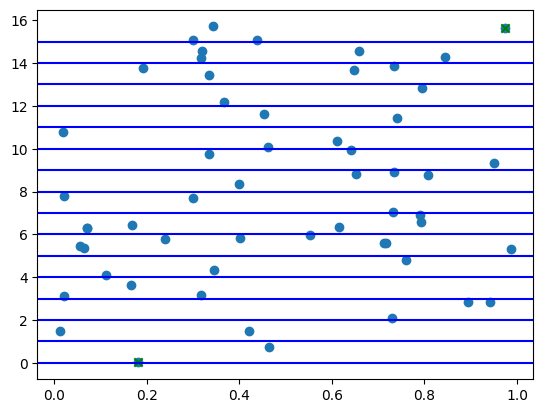

In [42]:
plotear([],R) #plot vacio

/tmp/ipykernel_89/2746618923.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([ciudades[p[i][0]][p[i][1]][0],ciudades[p[i+1][0]][p[i+1][1]][0]],[ciudades[p[i][0]][p[i][1]][1],ciudades[p[i+1][0]][p[i+1][1]][1]],'k-',color= "g")


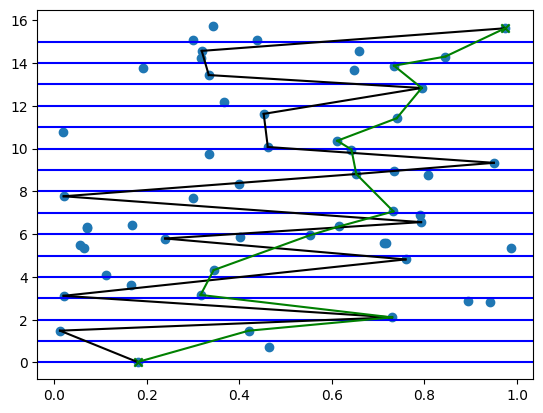

In [35]:
plotear(ruta,R,p) #sa inicial

/tmp/ipykernel_89/2746618923.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([ciudades[sigma[i][0]][sigma[i][1]][0],ciudades[sigma[i+1][0]][sigma[i+1][1]][0]],[ciudades[sigma[i][0]][sigma[i][1]][1],ciudades[sigma[i+1][0]][sigma[i+1][1]][1]],'k-',color="r")
/tmp/ipykernel_89/2746618923.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([ciudades[p[i][0]][p[i][1]][0],ciudades[p[i+1][0]][p[i+1][1]][0]],[ciudades[p[i][0]][p[i][1]][1],ciudades[p[i+1][0]][p[i+1][1]][1]],'k-',color= "g")


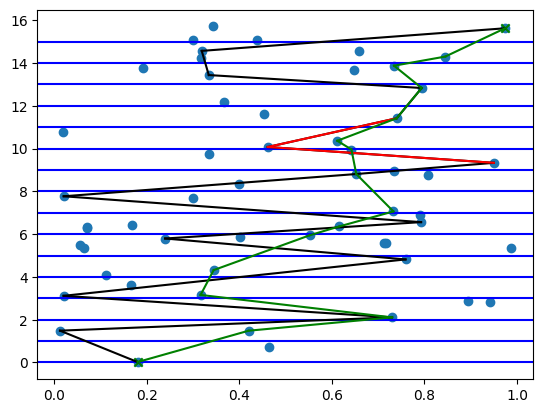

In [36]:
plotear(S21[1],R,p,index=[9,10]) #avance

/tmp/ipykernel_89/2746618923.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([ciudades[sigma[i][0]][sigma[i][1]][0],ciudades[sigma[i+1][0]][sigma[i+1][1]][0]],[ciudades[sigma[i][0]][sigma[i][1]][1],ciudades[sigma[i+1][0]][sigma[i+1][1]][1]],'k-',color="r")
/tmp/ipykernel_89/2746618923.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([ciudades[p[i][0]][p[i][1]][0],ciudades[p[i+1][0]][p[i+1][1]][0]],[ciudades[p[i][0]][p[i][1]][1],ciudades[p[i+1][0]][p[i+1][1]][1]],'k-',color= "g")


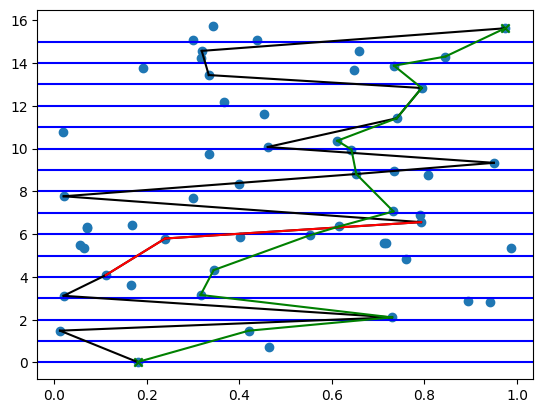

In [37]:
plotear(S21[2],R,p,[4,5]) #avance

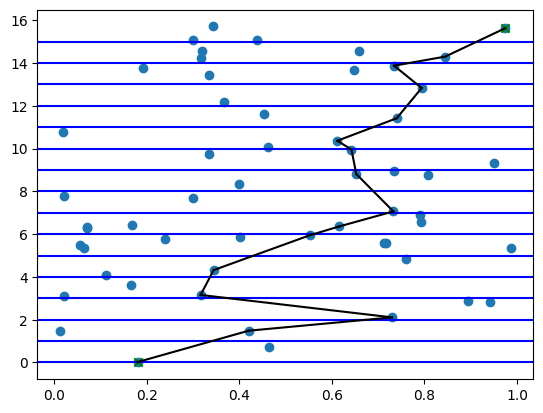

In [23]:
plotear(p,R) #ploteamos Dijkstra

/tmp/ipykernel_89/2746618923.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([ciudades[p[i][0]][p[i][1]][0],ciudades[p[i+1][0]][p[i+1][1]][0]],[ciudades[p[i][0]][p[i][1]][1],ciudades[p[i+1][0]][p[i+1][1]][1]],'k-',color= "g")


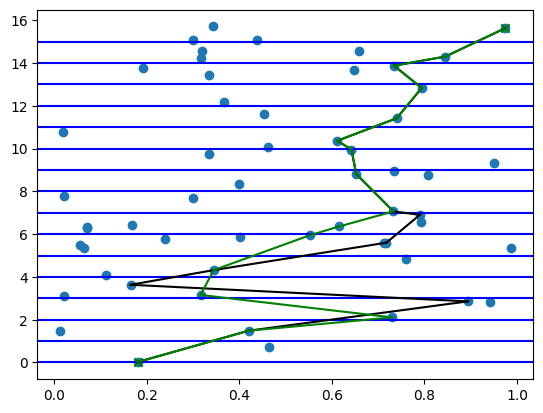

In [41]:
plotear(S21[50],R,p)

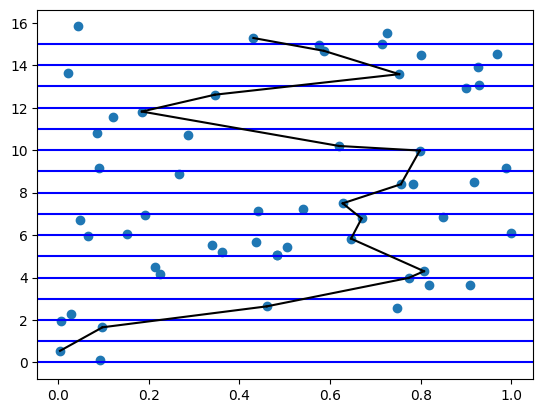

In [ ]:
plotear(s23,R)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45a688e7-b6e2-4e4a-b3a9-c39f5b699a07' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>